In [1]:
library(repr)
options(repr.plot.width=10,repr.plot.height=7)

In [2]:
# Fast but approximate solution under Sqrt assumptions

sig <- 0.01;
ADV <- 48000000;
n <- 480000;
t <- 24/390;
vavg <- n/(ADV*t+n);

In [12]:
# Instantaneous market impact functions
# LLOB approximation.
f_llob <- function(v, sigma = pi / 4) {
  # Sgima = pi/4 is an approximation.
  # sigma <- 0.785186408814605
  m <- log(pi)
  v <- abs(v)
  res <- sqrt(2 * v) * exp((-sqrt((log(v) - m)^2 + sigma^2) - m + log(v)) / 4)
    return(res)
}

In [13]:
# f <- function(v) {f_llob(v) }

#f <- function(v) { 0*f_barrier(v) + f_llob(v * 10e3) }
# f <- function(v) {v }
f <- f_llob

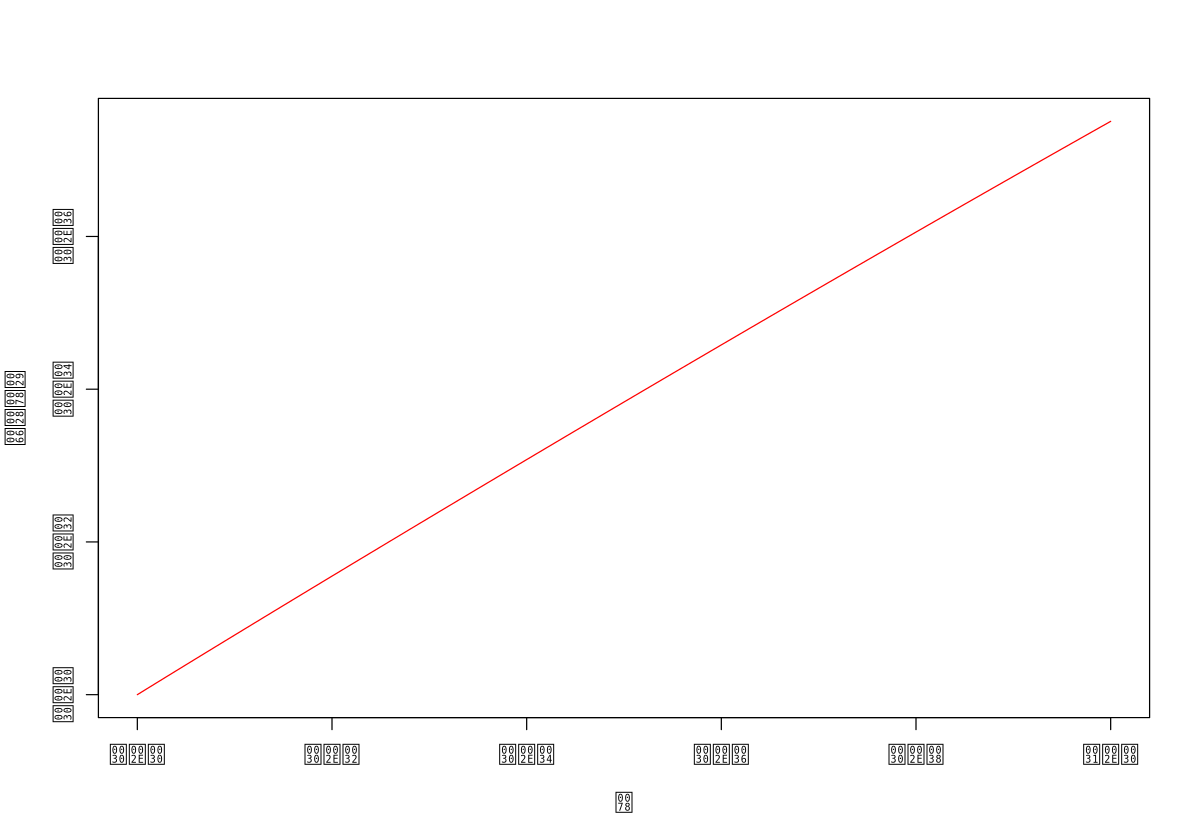

In [14]:
curve(f(x),from=0,to=1,col="red")

### Create a schedule with fixed times but variable quantities subject to total

In [7]:
# Generate an uneven schedule of interval VWAPs
schedule.U <- function(nShares, p.vec, T) {
    
  nSlices <- length(p.vec)  
  dT <- T/nSlices
  ti <- (1:nSlices) * dT
  vi <- p.vec*nShares/ADV
  fvi <- f(vi)
  sched.e <- data.frame(ti,p.vec*nShares,vi,fvi) 
     
sched <- rbind(c(0,0,0,0),sched.e)
  colnames(sched) <- c("Time", "nShrs", "volFrac","f_vi")
  return(sched)
}

In [8]:
# pj computes the impact of all prior executions on the price in the jth bucket (from t[j] to t[j+1))
pj <- function(t, v, fv, j) {
  pj <- fv[j] * sqrt(t[j + 1] - t[j]) # Self-interaction term
  if (j > 1) {
    for (i in 1:(j - 1))
    {
      decay <- ((t[j + 1] - t[i])^(3 / 2) - (t[j] - t[i])^(3 / 2) - (t[j + 1] - t[i + 1])^(3 / 2) + (t[j] - t[i + 1])^(3 / 2)) / (t[j + 1] - t[j])
      pj <- pj + decay * fv[i]
    }
  }
  return(pj)
}

In [9]:
# Finally, the function that costs a particular schedule
costSchedule <- function(sched) {
  tt <- sched[, 1] # Remember that first element is t=0!
  m <- length(tt)
  dt <- diff(tt)
  nn <- sched[, 2][2:m]
  v <- nn / (ADV * dt + nn*0) # Volume fractions include own volume in denominator!
  ff <- function(vv) {
    f(vv)
  }
  fv <- as.numeric(lapply(v, ff))
  cost <- 0
  for (j in 1:(m - 1)) {
    cost <- cost + nn[j] * pj(tt, v, fv, j)
  }
  return(cost * sig / n)
}

In [10]:
obj <- function(nShares,T)function(p.vec){
    
    p.vec2 <- p.vec/sum(p.vec)
    #print(p.vec2)
    costSchedule(schedule.U(nShares,p.vec2, T))
}

In [11]:
obj(480e3,.5)(p.vec=c(100,rep(0,11)))

[1] 0.0004898979

In [12]:
p.vec <- c(100,rep(0,11))

In [13]:
(res.optim <- optim(p.vec,obj(480000,.5),method="L-BFGS-B",lower=rep(0,length(p.vec)),upper=rep(1,length(p.vec))))

$par
 [1] 0.3535161 0.2403609 0.2240566 0.2090975 0.2034124 0.2006747 0.2005895
 [8] 0.2033627 0.2097373 0.2215112 0.2414828 0.3526274

$value
[1] 0.0001395132

$counts
function gradient 
      13       13 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

In [14]:
sum(res.optim$par)

[1] 2.860429

In [15]:
# Finally, finally, a function to compute the optimal strategy given theta (the characteristic timescale)
optimaUnevenStrategy <- function(nShares,T)function(p.vec) {

    p.l <- length(p.vec)
    res <- optim(p.vec,obj(nShares,T),method="L-BFGS-B",lower=rep(0,p.l),upper=rep(1,p.l))
    return(list(cost=res$value,p=res$par/sum(res$par)))
}

In [16]:
p.vec <- c(1,rep(0,99))

In [22]:
res.opt <- optimaUnevenStrategy(nShares=40e3,T=.5)(p.vec)

In [23]:
res.opt$cost

[1] 9.661039e-07

In [24]:
opt.theo <- function(p.vec){
    p.l <- length(p.vec)
    s.e <- (1:p.l)/p.l
    s.b <- (0:(p.l-1))/p.l
    s <- (s.b+s.e)/2
    sched.raw <- 1/(s*(1-s))^(1/4)
    sched <- sched.raw/sum(sched.raw)
    return(sched)
}

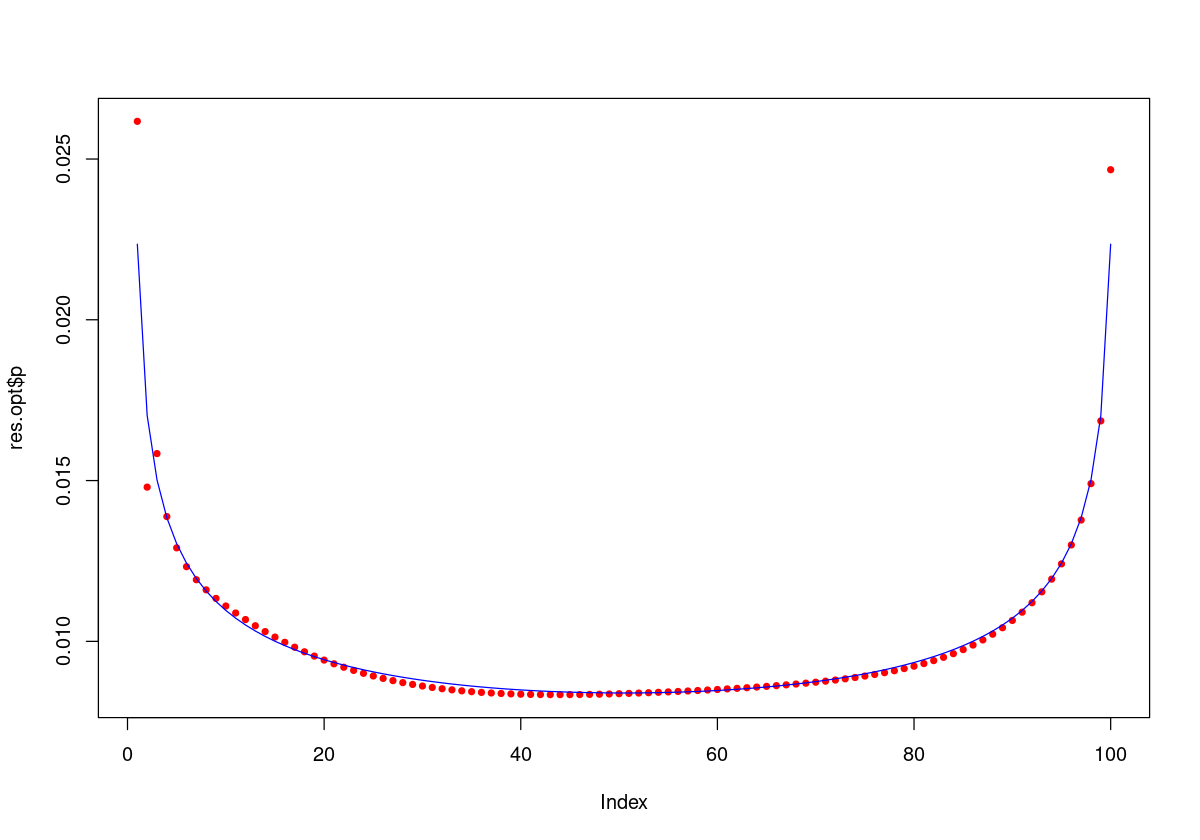

In [25]:
plot(res.opt$p,col="red",pch=20)
lines(1:length(p.vec),opt.theo(p.vec),col="blue")

In [21]:
optimaUnevenStrategy(nShares=4e3,T=.5)(p.vec)

$cost
[1] 9.820597e-08

$p
  [1] 9.999820e-01 1.148275e-07 1.431654e-07 1.532778e-07 1.591222e-07
  [6] 1.630656e-07 1.659605e-07 1.682035e-07 1.700081e-07 1.715009e-07
 [11] 1.727628e-07 1.738476e-07 1.747935e-07 1.756276e-07 1.763705e-07
 [16] 1.770377e-07 1.776411e-07 1.781905e-07 1.786933e-07 1.791558e-07
 [21] 1.795832e-07 1.799796e-07 1.803487e-07 1.806934e-07 1.810163e-07
 [26] 1.813196e-07 1.816052e-07 1.818748e-07 1.821299e-07 1.823716e-07
 [31] 1.826011e-07 1.828194e-07 1.830274e-07 1.832258e-07 1.834155e-07
 [36] 1.835969e-07 1.837708e-07 1.839375e-07 1.840976e-07 1.842515e-07
 [41] 1.843996e-07 1.845422e-07 1.846798e-07 1.848124e-07 1.849406e-07
 [46] 1.850644e-07 1.851842e-07 1.853001e-07 1.854124e-07 1.855213e-07
 [51] 1.856268e-07 1.857293e-07 1.858287e-07 1.859254e-07 1.860193e-07
 [56] 1.861107e-07 1.861996e-07 1.862861e-07 1.863704e-07 1.864526e-07
 [61] 1.865327e-07 1.866108e-07 1.866870e-07 1.867614e-07 1.868341e-07
 [66] 1.869050e-07 1.869744e-07 1.870421e-07 1.871084e-07 1.871733e-07
 [71] 1.872367e-07 1.872988e-07 1.873596e-07 1.874191e-07 1.874775e-07
 [76] 1.875346e-07 1.875907e-07 1.876456e-07 1.876995e-07 1.877523e-07
 [81] 1.878042e-07 1.878551e-07 1.879050e-07 1.879541e-07 1.880023e-07
 [86] 1.880496e-07 1.880961e-07 1.881418e-07 1.881867e-07 1.882308e-07
 [91] 1.882742e-07 1.883169e-07 1.883589e-07 1.884002e-07 1.884409e-07
 [96] 1.884809e-07 1.885203e-07 1.885591e-07 1.885972e-07 1.886348e-07